Targets: Above 99.4% test_acc with allowed number of params  
Results:  
    test_acc =  
        99.40% on 13th epoch  
        99.42% on 18th epoch

    total parameters = 7996  
Analysis:  Have very mild fluctuation in test acc from 13th epoch to 20th epoch. It has batch normalization, regularization, increased capacity, image augmentation, playing naively with learning rates.
File Link:  

# 1. Import external libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt


#### Basically working model
#### Img Aug RandomRotation
#### StepLR Scheduler
#### Train & Test Graphs

# 2. Convolutional Neural Network (model) architecture

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        set1 = 8 #channels
        set2 = 16 #channels
        out = 10 #channels
        avg = 7 #channels
        drop = 0.25 #dropout
        mom = 0.1
        self.conv1 = nn.Conv2d(1, set1, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=set1, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(set1, set1, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=set1, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(set1, set2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=set2, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.conv4 = nn.Conv2d(set2, out, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(out, out, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.conv6 = nn.Conv2d(out, out, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv7 = nn.Conv2d(out, out, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.conv8 = nn.Conv2d(out, out, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)
        self.conv9 = nn.Conv2d(out, out, 3)
        self.bn9 = nn.BatchNorm2d(num_features=out, eps=1e-05, momentum=mom, affine=True, track_running_stats=True)


        self.drop = nn.Dropout(drop)
        self.gap = nn.AvgPool2d(kernel_size=[avg,avg], stride=[avg,avg], padding=0, ceil_mode=False, count_include_pad=False)

    def forward(self, x):
        x = self.drop(self.pool1(self.bn2(F.relu(self.conv2(self.bn1(F.relu(self.conv1(x))))))))
        x = self.drop(self.pool2(self.bn4(F.relu(self.conv4(self.bn3(F.relu(self.conv3(x))))))))
        x = self.drop(self.pool3(self.bn6(F.relu(self.conv6(self.bn5(F.relu(self.conv5(x)))))))) # ToDo Try adding MP here
        x = self.drop(self.bn8(F.relu(self.conv8(self.bn7(F.relu(self.conv7(x))))))) # ToDo Try adding MP here
        x = self.conv9(x)
        #x = self.gap(x) # Raja ToDo Try printing shape here
        #print(x.shape)
        x = x.view(-1, 10) # Raja ToDo Try printing shape here
        return F.log_softmax(x)

#### RuntimeError: running_mean should contain 8 elements not 4
Implies check the bn channels, whether it matches with the ouput channel of its previous layer.

# 3. Display summary of model

In [ ]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() #bool
str_gpu_cpu = "cuda" if use_cuda else "cpu" #string
device = torch.device(str_gpu_cpu)
print("device is " + str_gpu_cpu)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

device is cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
           Dropout-6            [-1, 8, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,168
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 10, 14, 14]           1,450
      BatchNorm2d-10           [-1, 10, 14, 14]              20
        MaxPool2d-11             [-1, 10, 7, 7]               0
          Dropout-12             [-1, 10, 7, 7]               0
           Conv2d-13             [-1, 10, 7, 7]             910
      BatchNorm2d-14    

<ipython-input-15-b82138dca7db>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# 4. Preparation of dataset  

In [ ]:

SEED = 1
torch.manual_seed(SEED)
batch_size = 128
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        #transforms.RandomResizedCrop(size=(28, 28), antialias=True), #Not so good
                        #transforms.RandomAffine(20),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


# 5. Train and Test Functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch={epoch} loss={loss.item()} batch_id={batch_idx}')
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_losses.append(test_loss)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\n  Test set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))


# 6. Run the model with a device and an optimizer

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
ep = 21
for epoch in range(1, ep): #RAJA changed epochs
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

#With params = 7996, on 11th epoch, test accuracy = 99.21% with imgaug = RandomRotation only & batch_size = 128
#With params = 7996, on 13th epoch, test accuracy = 99.12% with imgaug = RandomRotation only & batch_size = 256
#With params = 7996, on 20th epoch, test accuracy = 98.9% with imgaug = RandomRotation only & batch_size = 512
#With params = 7996, on 17th epoch, test accuracy = 99.36% with imgaug = RandomRotation only & batch_size = 64 - Best till now
#With params = 7996, on 19th epoch, test accuracy = 99.24% with imgaug = RandomRotation only & batch_size = 32
#With params = 7996, on 10th epoch, test accuracy = 99.24% without imgaug & batch_size = 64
#With params = 7996, on 19th epoch, test accuracy = 99.22% with imgaug = RandomAffine & batch_size = 64
#With params = 7996, on 18th epoch, test accuracy = 99.12% with batch_size = 64 & imgaug = RandomRotation -6 to +6
#With params = 7996, on 18th epoch, test accuracy = 99.33% with batch_size = 64 & imgaug = RandomRotation -- fill = 0 & BN -- momentum=0.1
#With params = 7996, on 20th epoch, test accuracy = 99.33% with batch_size = 64 & imgaug = RandomRotation -- fill = 1 & BN -- momentum=0.2
#With params = 7996, on 19th epoch, test accuracy = 99.31% with batch_size = 64 & imgaug = RandomRotation -- fill = 1 & BN -- momentum=0.3

  0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-15-b82138dca7db>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
epoch=1 loss=0.10871642082929611 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.06it/s]



  Test set: Average loss: 0.0641, Test Accuracy: 9791/10000 (97.91%)



epoch=2 loss=0.04936870187520981 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.21it/s]



  Test set: Average loss: 0.0466, Test Accuracy: 9845/10000 (98.45%)



epoch=3 loss=0.035974279046058655 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.94it/s]



  Test set: Average loss: 0.0344, Test Accuracy: 9887/10000 (98.87%)



epoch=4 loss=0.011785987764596939 batch_id=937: 100%|██████████| 938/938 [00:29<00:00, 32.12it/s]



  Test set: Average loss: 0.0347, Test Accuracy: 9891/10000 (98.91%)



epoch=5 loss=0.05689550191164017 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.08it/s]



  Test set: Average loss: 0.0280, Test Accuracy: 9909/10000 (99.09%)



epoch=6 loss=0.21364378929138184 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.01it/s]



  Test set: Average loss: 0.0364, Test Accuracy: 9884/10000 (98.84%)



epoch=7 loss=0.017721248790621758 batch_id=937: 100%|██████████| 938/938 [00:29<00:00, 31.84it/s]



  Test set: Average loss: 0.0226, Test Accuracy: 9928/10000 (99.28%)



epoch=8 loss=0.007784928195178509 batch_id=937: 100%|██████████| 938/938 [00:29<00:00, 31.96it/s]



  Test set: Average loss: 0.0211, Test Accuracy: 9931/10000 (99.31%)



epoch=9 loss=0.01979091577231884 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.84it/s]



  Test set: Average loss: 0.0202, Test Accuracy: 9937/10000 (99.37%)



epoch=10 loss=0.008847636170685291 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.14it/s]



  Test set: Average loss: 0.0206, Test Accuracy: 9935/10000 (99.35%)



epoch=11 loss=0.022868318483233452 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.34it/s]



  Test set: Average loss: 0.0207, Test Accuracy: 9932/10000 (99.32%)



epoch=12 loss=0.07394594699144363 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.81it/s]



  Test set: Average loss: 0.0195, Test Accuracy: 9938/10000 (99.38%)



epoch=13 loss=0.04175505042076111 batch_id=937: 100%|██████████| 938/938 [00:29<00:00, 31.54it/s]



  Test set: Average loss: 0.0192, Test Accuracy: 9940/10000 (99.40%)



epoch=14 loss=0.016942691057920456 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.13it/s]



  Test set: Average loss: 0.0193, Test Accuracy: 9942/10000 (99.42%)



epoch=15 loss=0.07329491525888443 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.35it/s]



  Test set: Average loss: 0.0192, Test Accuracy: 9941/10000 (99.41%)



epoch=16 loss=0.08100681006908417 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 31.21it/s]



  Test set: Average loss: 0.0192, Test Accuracy: 9939/10000 (99.39%)



epoch=17 loss=0.013149090111255646 batch_id=937: 100%|██████████| 938/938 [00:31<00:00, 30.20it/s]



  Test set: Average loss: 0.0193, Test Accuracy: 9940/10000 (99.40%)



epoch=18 loss=0.1555497944355011 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.58it/s]



  Test set: Average loss: 0.0191, Test Accuracy: 9942/10000 (99.42%)



epoch=19 loss=0.04657673463225365 batch_id=937: 100%|██████████| 938/938 [00:29<00:00, 31.31it/s]



  Test set: Average loss: 0.0192, Test Accuracy: 9939/10000 (99.39%)



epoch=20 loss=0.06246306002140045 batch_id=937: 100%|██████████| 938/938 [00:30<00:00, 30.84it/s]



  Test set: Average loss: 0.0192, Test Accuracy: 9941/10000 (99.41%)



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

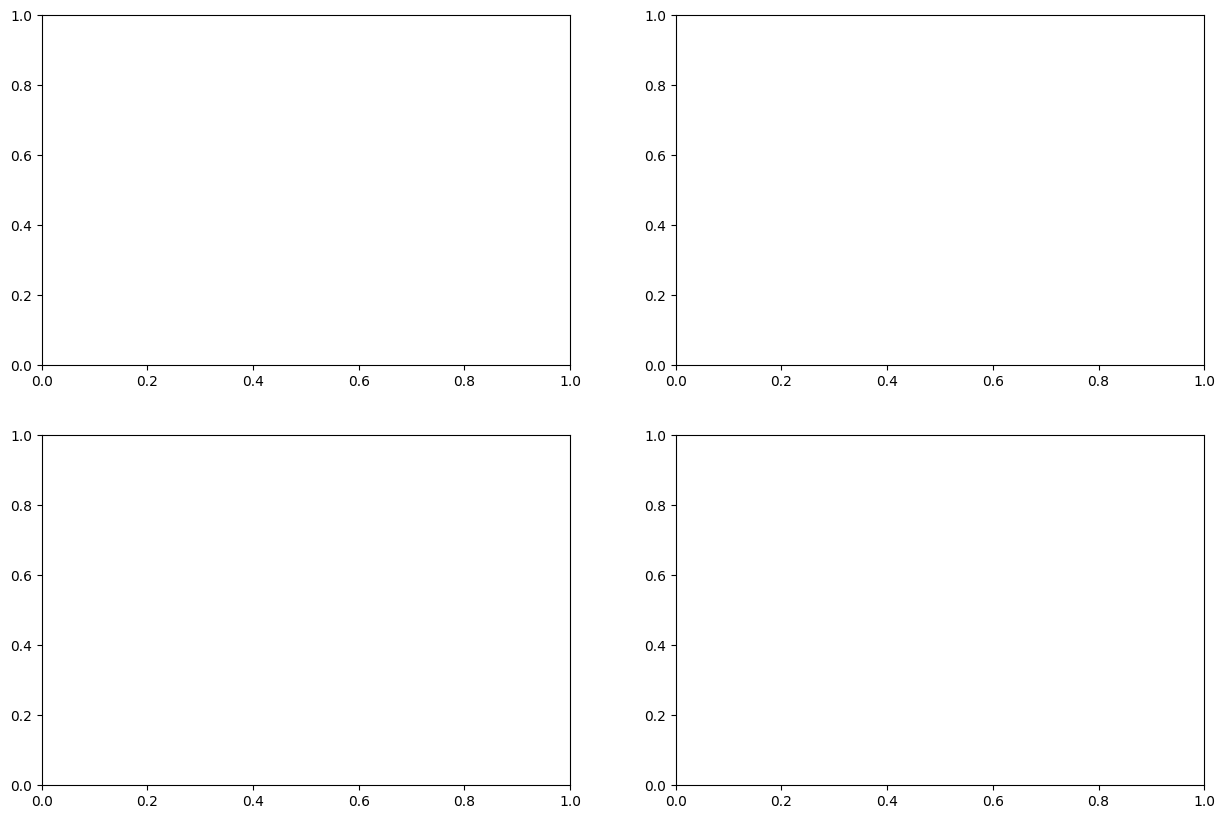

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Raja ToDo :
Try below ::
1. BatchNormalization - Done
2. Dropout  - Done
3. LR scheduler - Done
4. GAP - Done